# Imports & Libraries

In [175]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
import scipy

# Helper Functions

In [110]:
# Distribution plot
def distribution_plot(data):
    sns.displot(data, kind='hist', kde=True)
    plt.ylabel('Frequency')
    plt.title(f'{data.name} distribution')

In [111]:
# Functions for box plots 
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

def fillMissingCatColumns(data,categorical):
    for c in categorical:
        data[c] = data[c].astype('category')
        if data[c].isnull().any():
            data[c] = data[c].cat.add_categories(['MISSING'])
            data[c] = data[c].fillna('MISSING')
    
def getboxPlots(data,var,categorical):
    fillMissingCatColumns(data,categorical)
    f = pd.melt(data, id_vars=var, value_vars=categorical)
    g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
    g = g.map(boxplot, "value", var)

In [112]:
# Correlation Heatmap
def getCorrHeatMap(dataFrame,figSize=[12,9]):
    corrmat = dataFrame.corr()
    f, ax = plt.subplots(figsize=(figSize[0], figSize[1]))
    sns.heatmap(corrmat, vmax=.8, square=True);
    


def getZoomedCorrHeatMap(dataFrame,featureCount,target,figSize=[12,9]):
    corrmat = dataFrame.corr()
    cols = corrmat.nlargest(featureCount, target)[target].index
    f , ax = plt.subplots(figsize = (figSize[0],figSize[1]))
    cm = np.corrcoef(dataFrame[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

In [170]:
# Mahalanobis function outlier detection
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Loading Data 

In [113]:
data = pd.read_csv('StudentRecordsConcealed.csv', delimiter=',')


In [114]:
data.head()

,school id,school type,alevel math,olevel math,chem,phy,bio,english,ap course,cs ig,adv math,international student,transferred courses,major,specialization,cgpa,credit hours completed
0,EIBS,IG,0.0,65.0,35.0,35.0,35.0,65.0,0.0,0.0,0.0,0.0,0.0,BUS,BUS,1.71,57.0
1,DAIS,American,95.0,99.0,96.0,93.0,0.0,98.0,0.0,0.0,1.0,0.0,0.0,ENG,SDE,1.69,68.0
2,EBIS,IG,45.0,75.0,65.0,75.0,35.0,65.0,0.0,0.0,1.0,0.0,0.0,BUS,BUS,2.20,87.0
3,CIS,IG,75.0,65.0,75.0,75.0,75.0,75.0,0.0,0.0,1.0,0.0,0.0,BUS,BUS,1.76,54.0
4,BKS,American,87.0,87.0,0.0,94.0,0.0,90.0,0.0,0.0,1.0,0.0,0.0,BUS,BUS,2.00,53.0


In [115]:
data.columns

Index(['school id', 'school type', 'alevel math', 'olevel math', 'chem', 'phy',
       'bio', 'english', 'ap course', 'cs ig', 'adv math',
       'international student', 'transferred courses', 'major',
       'specialization', 'cgpa', 'credit hours completed'],
      dtype='object')

Removing White Space & Set Categorical Features to Lowercase

In [116]:
data['school id'] = data['school id'].str.replace(" ", "")
data['school id'] = data['school id'].str.lower()

data['school type'] = data['school type'].str.replace(" ", "")
data['school type'] = data['school type'].str.lower()

data['major'] = data['major'].str.replace(" ", "")
data['major'] = data['major'].str.lower()

data['specialization'] = data['specialization'].str.replace(" ", "")
data['specialization'] = data['specialization'].str.lower()

In [117]:
data.head()

,school id,school type,alevel math,olevel math,chem,phy,bio,english,ap course,cs ig,adv math,international student,transferred courses,major,specialization,cgpa,credit hours completed
0,eibs,ig,0.0,65.0,35.0,35.0,35.0,65.0,0.0,0.0,0.0,0.0,0.0,bus,bus,1.71,57.0
1,dais,american,95.0,99.0,96.0,93.0,0.0,98.0,0.0,0.0,1.0,0.0,0.0,eng,sde,1.69,68.0
2,ebis,ig,45.0,75.0,65.0,75.0,35.0,65.0,0.0,0.0,1.0,0.0,0.0,bus,bus,2.20,87.0
3,cis,ig,75.0,65.0,75.0,75.0,75.0,75.0,0.0,0.0,1.0,0.0,0.0,bus,bus,1.76,54.0
4,bks,american,87.0,87.0,0.0,94.0,0.0,90.0,0.0,0.0,1.0,0.0,0.0,bus,bus,2.00,53.0


# Data Exploration

## Univariate Exploration

Numerical Variables

In [118]:
numerical_features = ['alevel math', 'olevel math', 'chem', 'phy', 'bio', 'english', 
                      'transferred courses', 'cgpa', 'credit hours completed']

data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
alevel math,297.0,28.111111,40.006812,0.00,0.000,0.00,75.00,100.0
olevel math,299.0,75.391304,22.076987,0.00,70.000,78.00,88.00,100.0
chem,298.0,66.563758,30.631446,0.00,65.000,75.00,86.75,100.0
phy,297.0,58.565657,35.788841,0.00,45.000,74.00,85.00,100.0
bio,297.0,54.070707,37.490337,0.00,0.000,69.00,85.00,100.0
english,299.0,80.812709,14.156545,0.00,70.000,84.00,93.00,100.0
ap course,298.0,0.013423,0.115270,0.00,0.000,0.00,0.00,1.0
cs ig,298.0,0.130872,0.337828,0.00,0.000,0.00,0.00,1.0
adv math,298.0,0.338926,0.474141,0.00,0.000,0.00,1.00,1.0
international student,299.0,0.090301,0.287093,0.00,0.000,0.00,0.00,1.0


Distributions, Skewness & Kurtosis 

Skewness: 0.805723
Kurtosis: -1.220720


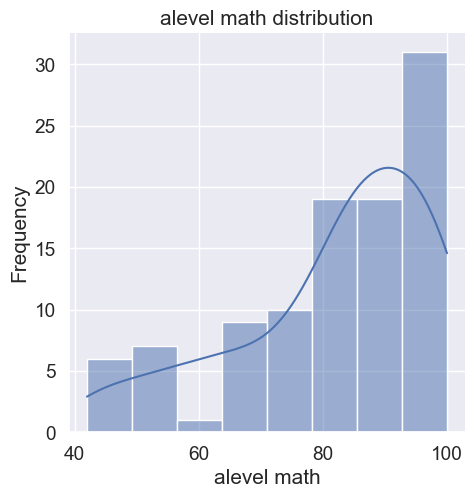

In [119]:
zero_val = data[data['alevel math'] != 0]
zero_val['alevel math']
distribution_plot(zero_val['alevel math'])
print("Skewness: %f" % data['alevel math'].skew())
print("Kurtosis: %f" % data['alevel math'].kurt())

Skewness: -2.146703
Kurtosis: 5.181387


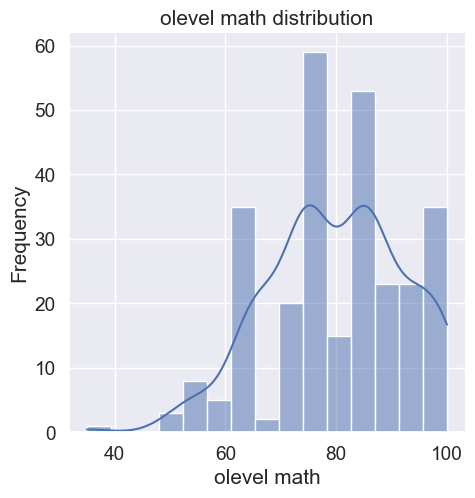

In [120]:
zero_val = data[data['olevel math'] != 0]
zero_val['olevel math']
distribution_plot(zero_val['olevel math'])
print("Skewness: %f" % data['olevel math'].skew())
print("Kurtosis: %f" % data['olevel math'].kurt())

Skewness: -1.279146
Kurtosis: 0.505833


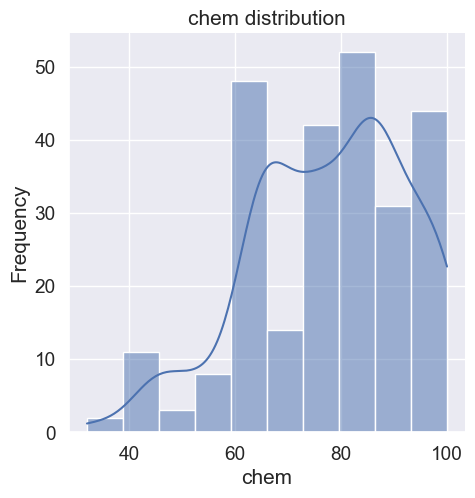

In [121]:
zero_val = data[data['chem'] != 0]
zero_val['chem']
distribution_plot(zero_val['chem'])
print("Skewness: %f" % data['chem'].skew())
print("Kurtosis: %f" % data['chem'].kurt())

Skewness: -0.764402
Kurtosis: -0.941373


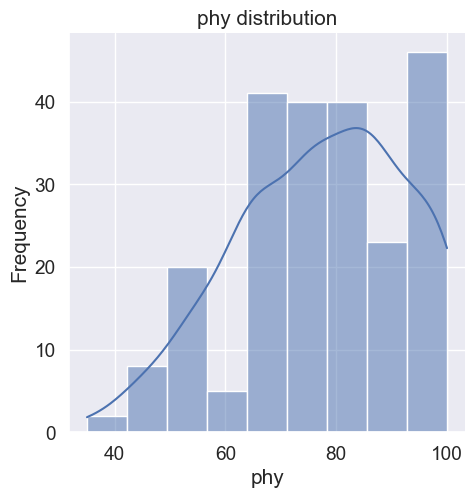

In [122]:
zero_val = data[data['phy'] != 0]
zero_val['phy']
distribution_plot(zero_val['phy'])
print("Skewness: %f" % data['phy'].skew())
print("Kurtosis: %f" % data['phy'].kurt())

Skewness: -0.545380
Kurtosis: -1.358490


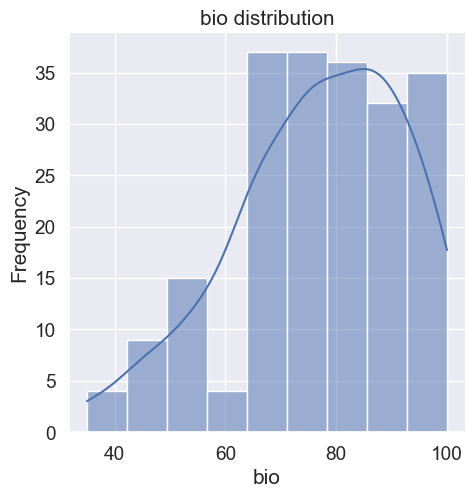

In [123]:
zero_val = data[data['bio'] != 0]
zero_val['bio']
distribution_plot(zero_val['bio'])
print("Skewness: %f" % data['bio'].skew())
print("Kurtosis: %f" % data['bio'].kurt())

Skewness: -0.872001
Kurtosis: 2.438658


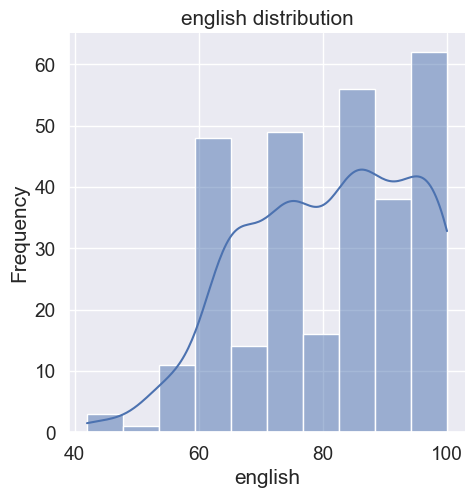

In [124]:
zero_val = data[data['english'] != 0]
zero_val['english']
distribution_plot(zero_val['english'])
print("Skewness: %f" % data['english'].skew())
print("Kurtosis: %f" % data['english'].kurt())

Skewness: 7.061565
Kurtosis: 54.950376


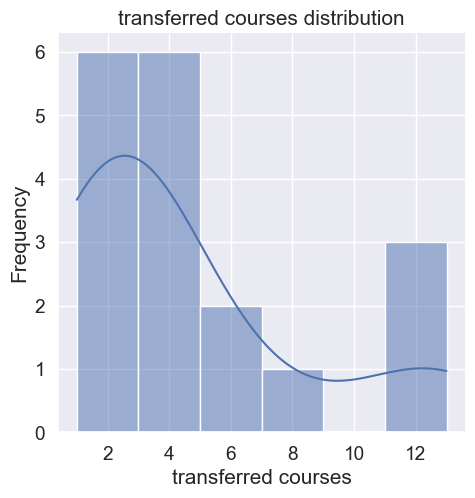

In [125]:
zero_val = data[data['transferred courses'] != 0]
zero_val['transferred courses']
distribution_plot(zero_val['transferred courses'])
print("Skewness: %f" % data['transferred courses'].skew())
print("Kurtosis: %f" % data['transferred courses'].kurt())

Skewness: 0.148447
Kurtosis: -0.965700


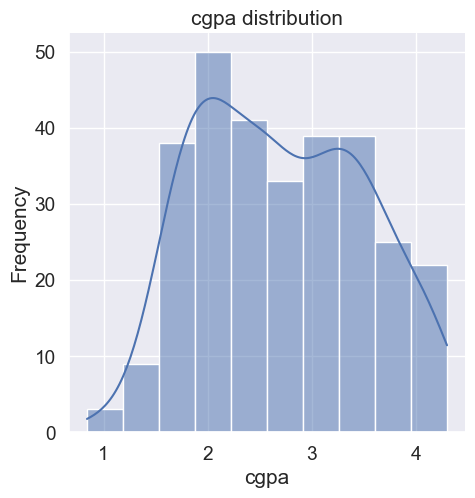

In [126]:
zero_val = data[data['cgpa'] != 0]
zero_val['cgpa']
distribution_plot(zero_val['cgpa'])
print("Skewness: %f" % data['cgpa'].skew())
print("Kurtosis: %f" % data['cgpa'].kurt())

Skewness: 0.374649
Kurtosis: -0.934295


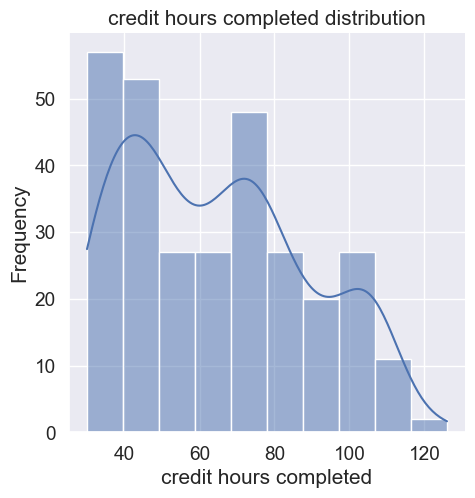

In [127]:
zero_val = data[data['credit hours completed'] != 0]
zero_val['credit hours completed']
distribution_plot(zero_val['credit hours completed'])
print("Skewness: %f" % data['credit hours completed'].skew())
print("Kurtosis: %f" % data['credit hours completed'].kurt())

Categorical Variables

In [128]:
school_id = data['school id'].astype('category')
school_id.describe()

count      300
unique     138
top       ebis
freq        19
Name: school id, dtype: object

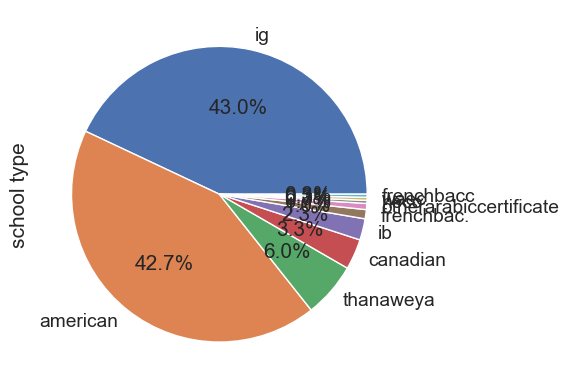

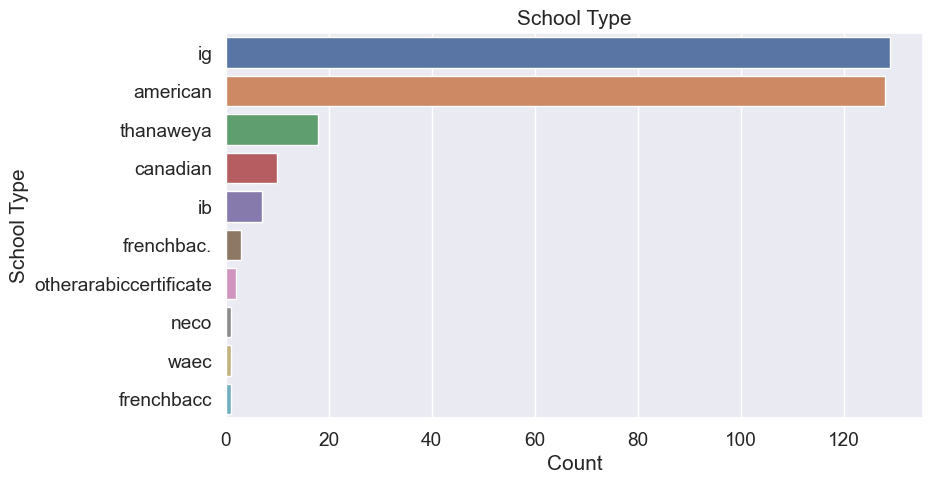

In [129]:
# pie plot
data['school type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['school type'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='school type', order=order)
plt.title('School Type')
plt.xlabel('Count')
plt.ylabel('School Type');

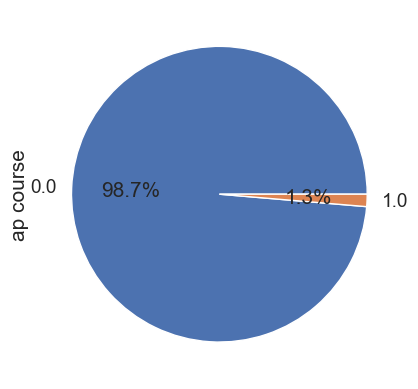

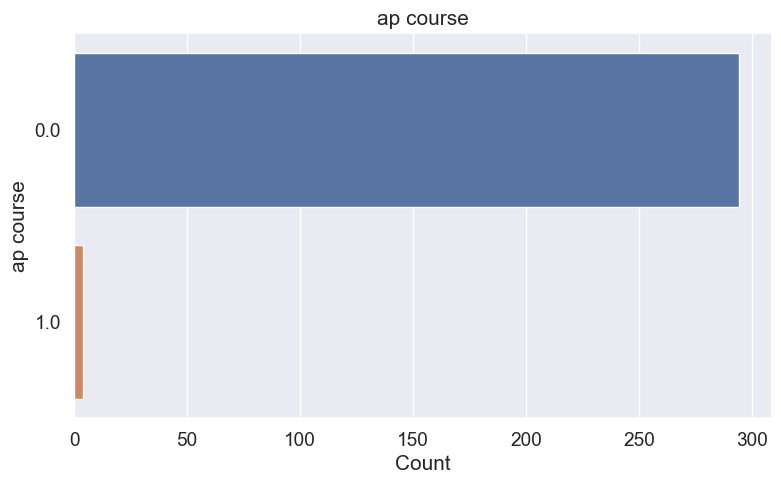

In [130]:
# pie plot
data['ap course'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['ap course'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='ap course', order=order)
plt.title('ap course')
plt.xlabel('Count')
plt.ylabel('ap course');

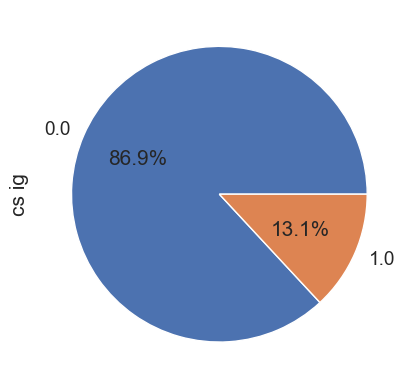

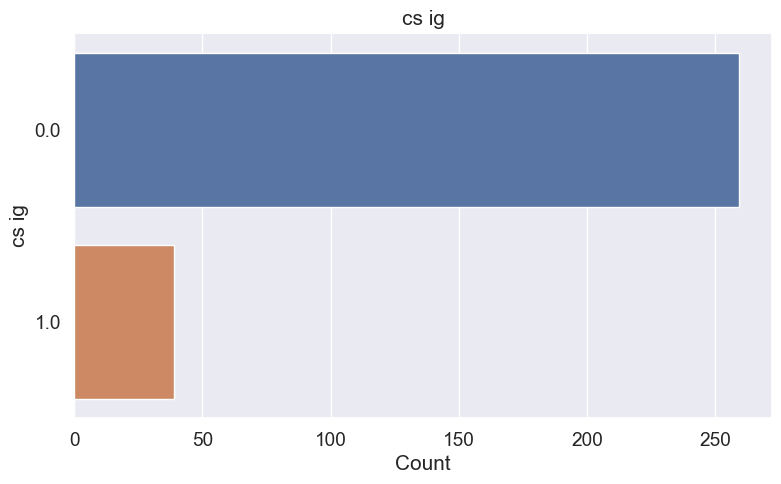

In [131]:
# pie plot
data['cs ig'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['cs ig'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='cs ig', order=order)
plt.title('cs ig')
plt.xlabel('Count')
plt.ylabel('cs ig');

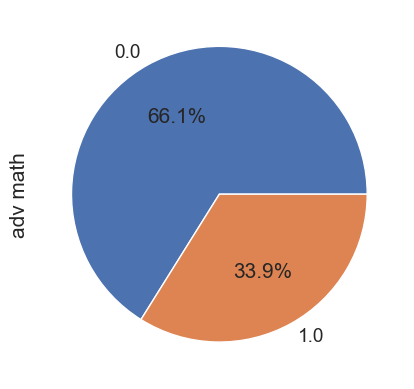

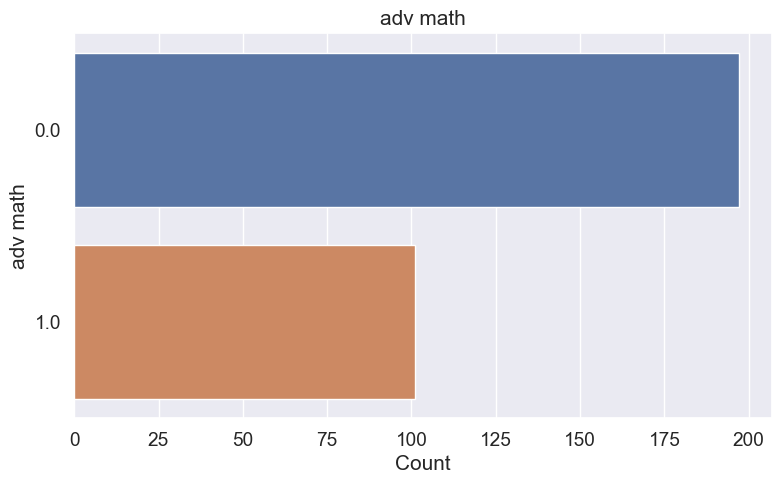

In [132]:
# pie plot
data['adv math'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['adv math'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='adv math', order=order)
plt.title('adv math')
plt.xlabel('Count')
plt.ylabel('adv math');

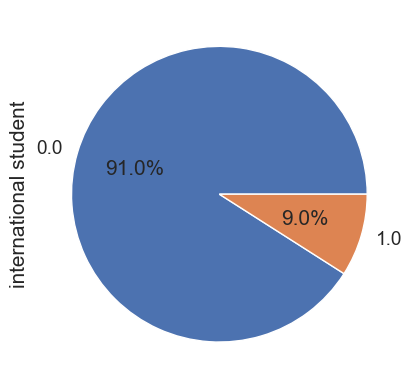

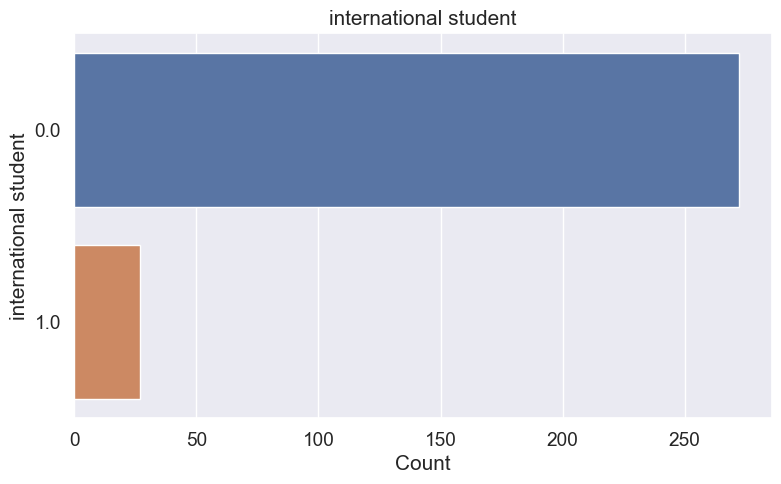

In [133]:
# pie plot
data['international student'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['international student'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='international student', order=order)
plt.title('international student')
plt.xlabel('Count')
plt.ylabel('international student');

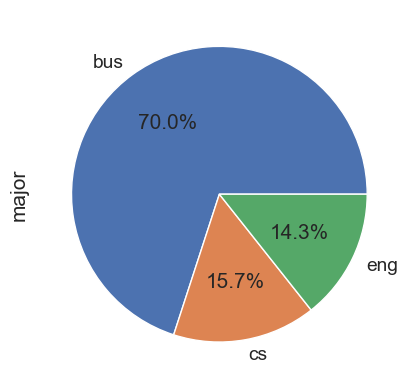

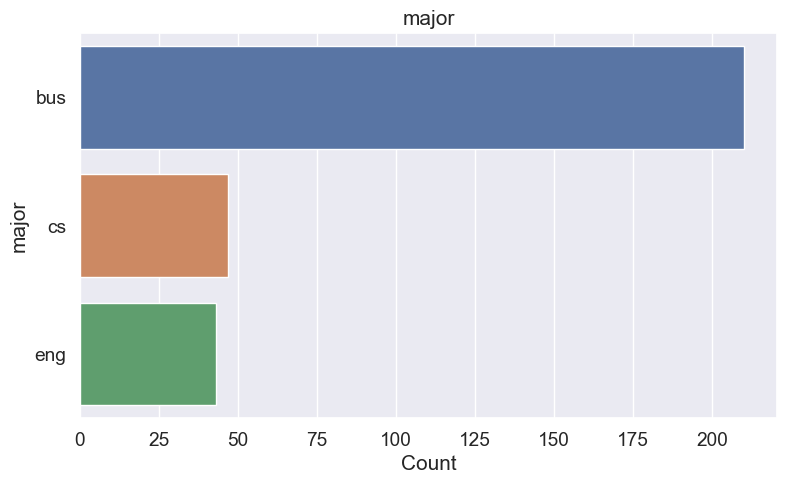

In [134]:
# pie plot
data['major'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['major'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='major', order=order)
plt.title('major')
plt.xlabel('Count')
plt.ylabel('major');

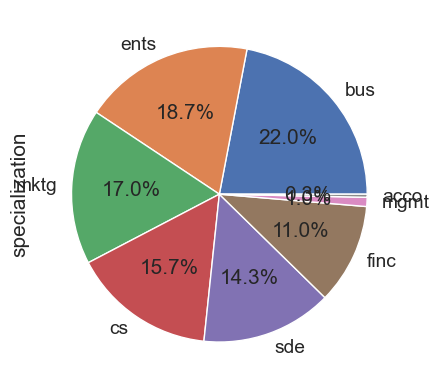

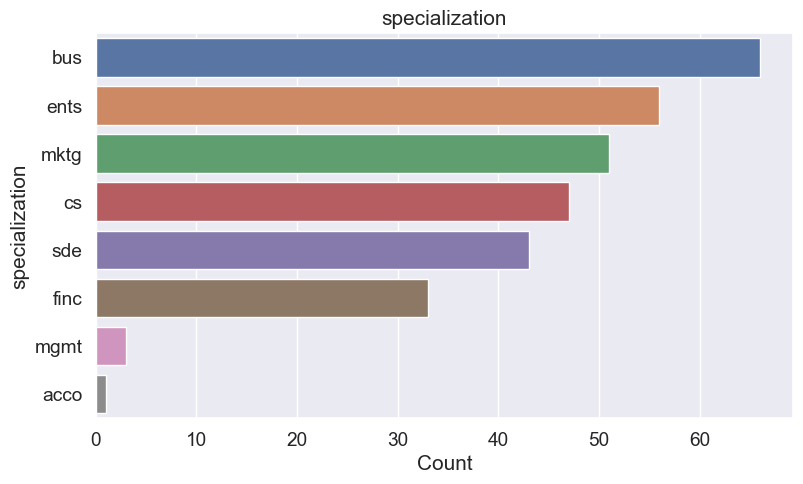

In [135]:
# pie plot
data['specialization'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['specialization'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='specialization', order=order)
plt.title('specialization')
plt.xlabel('Count')
plt.ylabel('specialization');

## Bivariate Exploration

Numerical-Numerical

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='alevel math', ylabel='cgpa'>

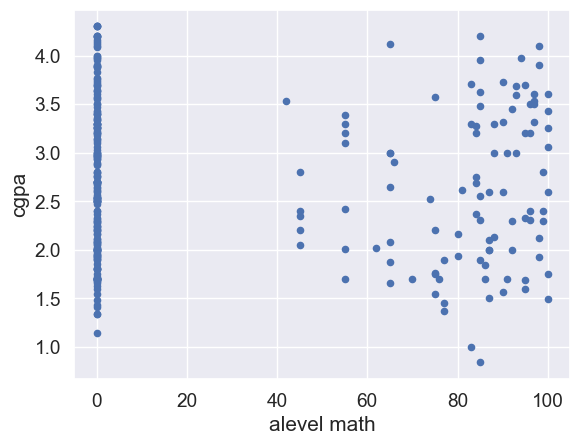

In [136]:
data.plot.scatter(x='alevel math', y='cgpa')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='olevel math', ylabel='cgpa'>

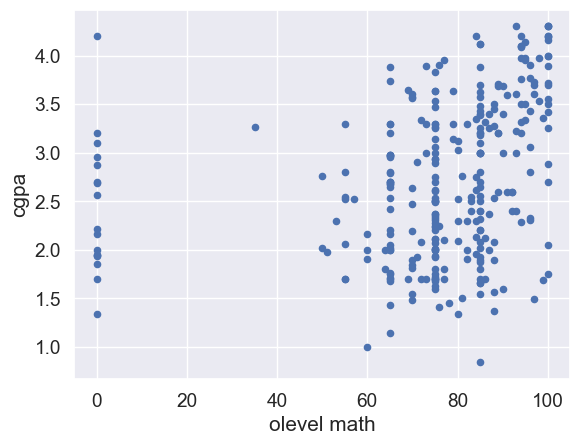

In [137]:
data.plot.scatter(x='olevel math', y='cgpa')

array([[<AxesSubplot:xlabel='alevel math', ylabel='alevel math'>,
        <AxesSubplot:xlabel='olevel math', ylabel='alevel math'>,
        <AxesSubplot:xlabel='chem', ylabel='alevel math'>,
        <AxesSubplot:xlabel='phy', ylabel='alevel math'>,
        <AxesSubplot:xlabel='bio', ylabel='alevel math'>,
        <AxesSubplot:xlabel='english', ylabel='alevel math'>,
        <AxesSubplot:xlabel='ap course', ylabel='alevel math'>,
        <AxesSubplot:xlabel='cs ig', ylabel='alevel math'>,
        <AxesSubplot:xlabel='adv math', ylabel='alevel math'>,
        <AxesSubplot:xlabel='international student', ylabel='alevel math'>,
        <AxesSubplot:xlabel='transferred courses', ylabel='alevel math'>,
        <AxesSubplot:xlabel='cgpa', ylabel='alevel math'>,
        <AxesSubplot:xlabel='credit hours completed', ylabel='alevel math'>],
       [<AxesSubplot:xlabel='alevel math', ylabel='olevel math'>,
        <AxesSubplot:xlabel='olevel math', ylabel='olevel math'>,
        <AxesSubplot:xlab

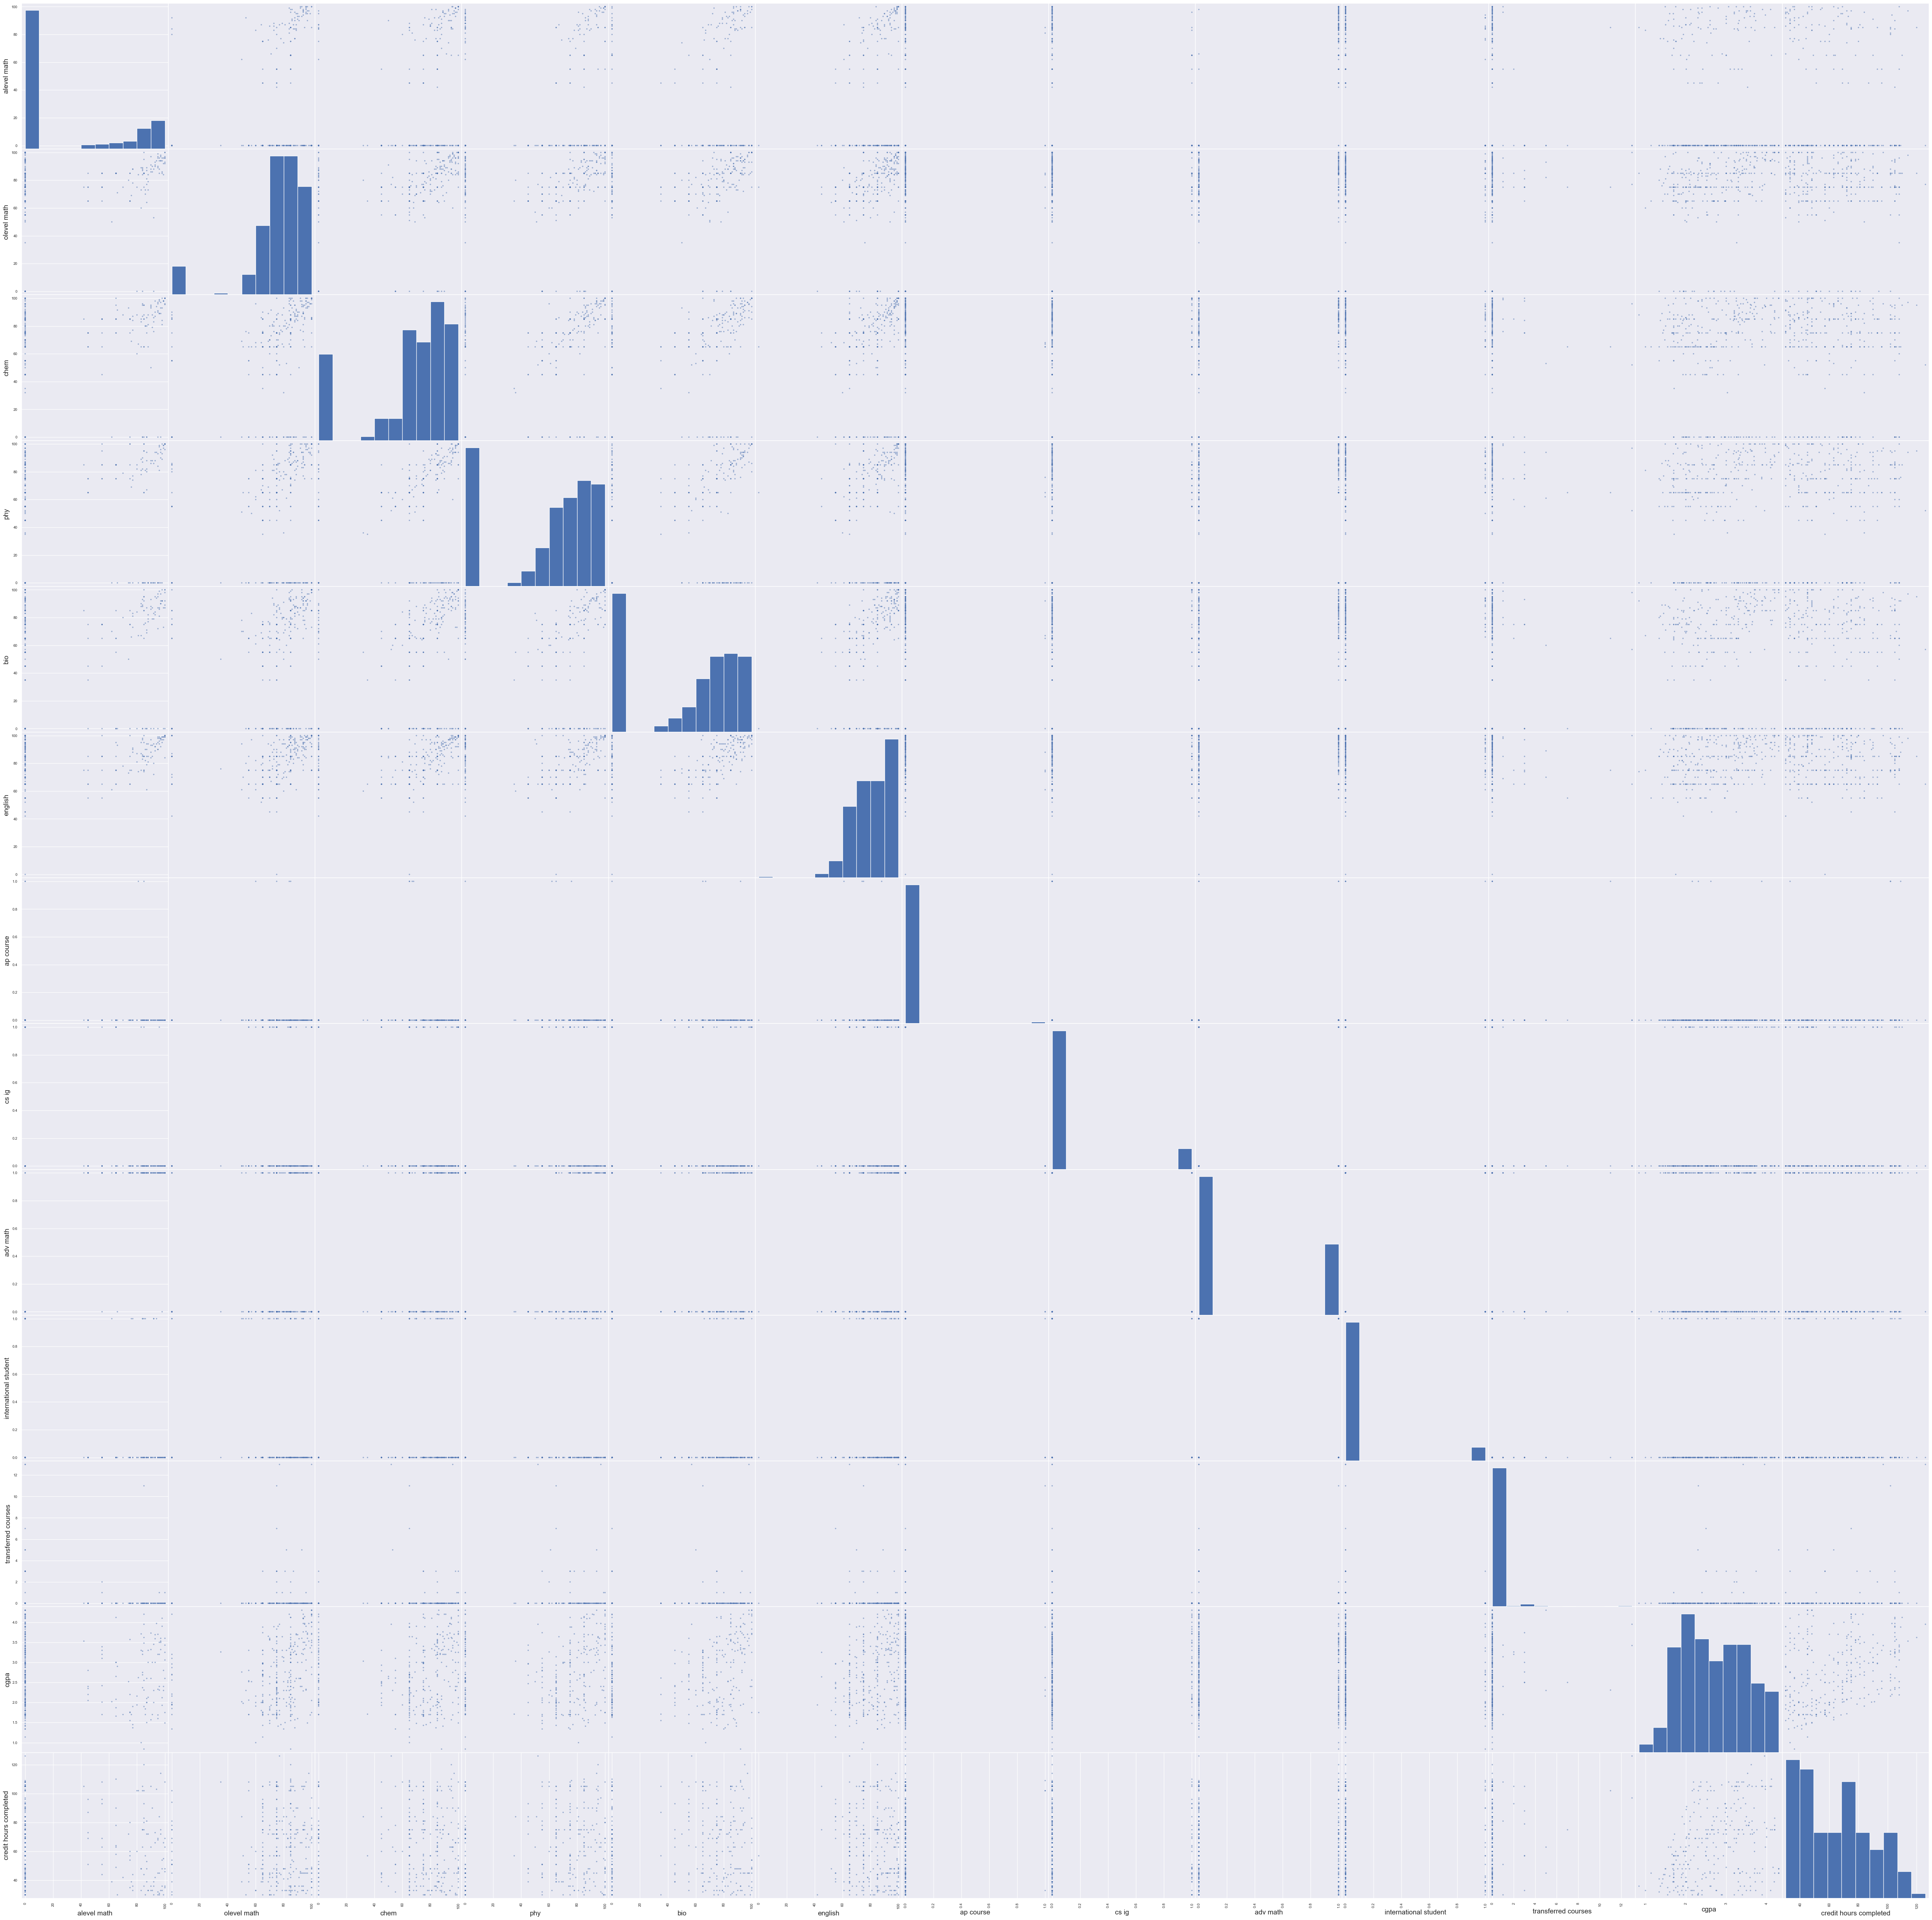

In [138]:
pd.plotting.scatter_matrix(data, figsize=(75,75), grid=True)

Numerical-Categorical

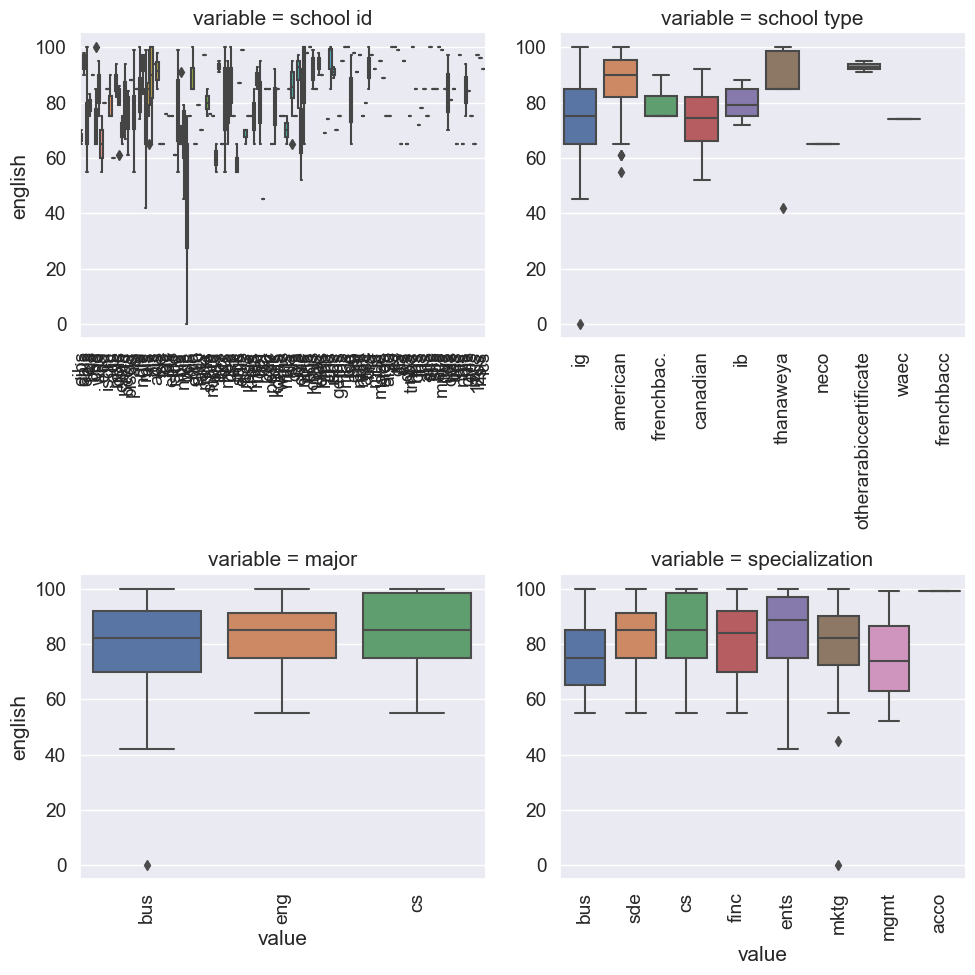

In [139]:
data_copy = data.copy()
categorical_features = [f for f in data_copy.columns if data_copy.dtypes[f] == 'object']

getboxPlots(data_copy, 'english', categorical_features)

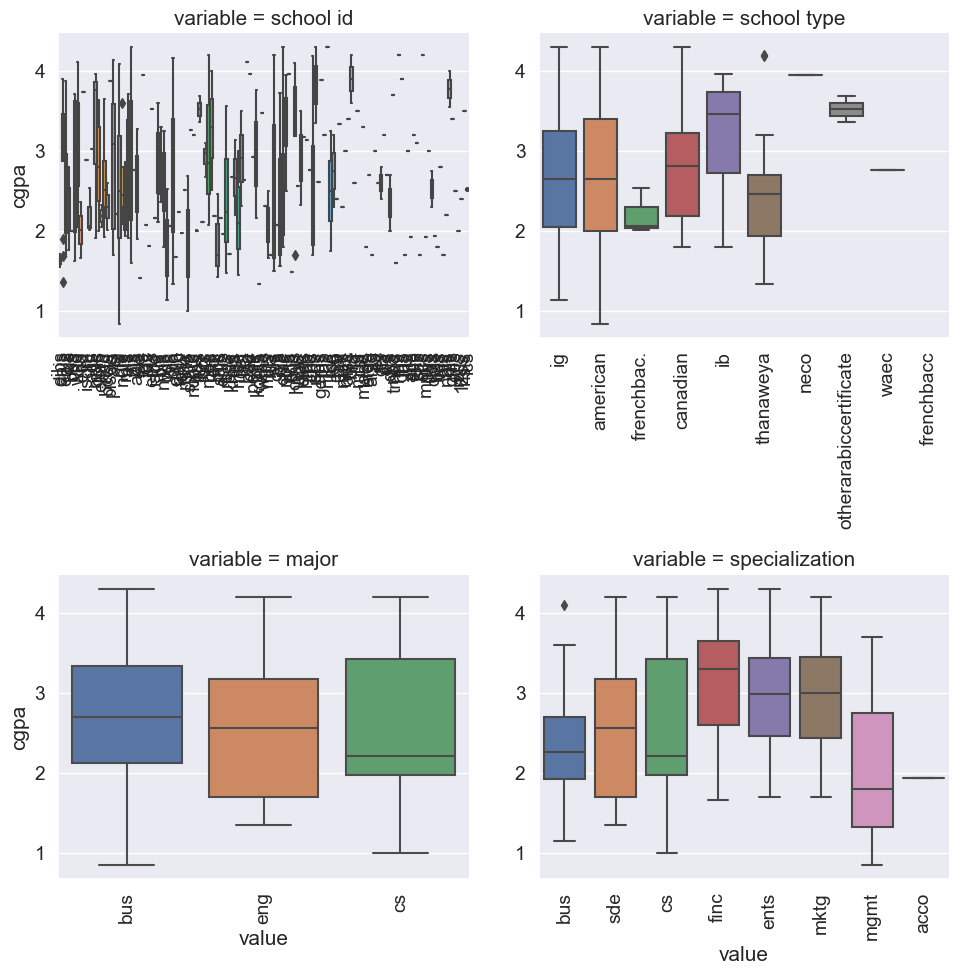

In [140]:
getboxPlots(data_copy, 'cgpa', categorical_features)

Categorical-Categorical

In [141]:
# School type and specialization
compare = pd.crosstab(data['school type'], data['specialization'])

print(compare)

chi2, p, dof, ex = stats.chi2_contingency(compare)

print(f'Chi_square value {chi2}\n\np value {p}\n\ndegrees of freedom {dof}\n\n expected {ex}')

specialization          acco  bus  cs  ents  finc  mgmt  mktg  sde
school type                                                       
american                   1   25  16    35    13     2    21   15
canadian                   0    2   1     1     2     1     2    1
frenchbac.                 0    1   2     0     0     0     0    0
frenchbacc                 0    0   1     0     0     0     0    0
ib                         0    0   0     1     1     0     5    0
ig                         0   36  21    16    15     0    20   21
neco                       0    0   0     0     0     0     0    1
otherarabiccertificate     0    0   0     0     1     0     1    0
thanaweya                  0    2   5     3     1     0     2    5
waec                       0    0   1     0     0     0     0    0
Chi_square value 76.35971670672092

p value 0.12028047708313964

degrees of freedom 63

 expected [[4.26666667e-01 2.81600000e+01 2.00533333e+01 2.38933333e+01
  1.40800000e+01 1.28000000e+00 2.17

Correlation Analysis

In [142]:
data.corr()

,alevel math,olevel math,chem,phy,bio,english,ap course,cs ig,adv math,international student,transferred courses,cgpa,credit hours completed
alevel math,1.000000,0.226668,0.270299,0.109873,0.277245,0.322896,0.039169,-0.117898,0.941519,0.021407,-0.056403,-0.056300,-0.111382
olevel math,0.226668,1.000000,0.341651,0.201783,0.277168,0.276726,0.003209,0.081885,0.202095,-0.061185,0.055978,0.284992,0.003875
chem,0.270299,0.341651,1.000000,0.352203,0.356991,0.235052,-0.001217,0.048756,0.247816,0.048084,0.015157,0.071034,-0.055510
phy,0.109873,0.201783,0.352203,1.000000,0.109371,0.084000,-0.025490,0.069235,0.117283,0.013679,0.074554,0.075112,0.125249
bio,0.277245,0.277168,0.356991,0.109371,1.000000,0.365571,0.006247,-0.095165,0.250101,0.043526,0.021223,0.231777,-0.017737
english,0.322896,0.276726,0.235052,0.084000,0.365571,1.000000,-0.053025,0.019739,0.228219,0.084265,-0.042677,0.324714,-0.066416
ap course,0.039169,0.003209,-0.001217,-0.025490,0.006247,-0.053025,1.000000,-0.045263,0.039692,0.064771,0.203563,0.004300,0.106395
cs ig,-0.117898,0.081885,0.048756,0.069235,-0.095165,0.019739,-0.045263,1.000000,-0.088666,-0.018495,-0.066264,0.111971,-0.048122
adv math,0.941519,0.202095,0.247816,0.117283,0.250101,0.228219,0.039692,-0.088666,1.000000,0.020968,-0.055412,-0.079444,-0.069919
international student,0.021407,-0.061185,0.048084,0.013679,0.043526,0.084265,0.064771,-0.018495,0.020968,1.000000,-0.034721,-0.068422,-0.037451


Pandas Profiling Report

# Data Preprocessing

In [143]:
data

,school id,school type,alevel math,olevel math,chem,phy,bio,english,ap course,cs ig,adv math,international student,transferred courses,major,specialization,cgpa,credit hours completed
0,eibs,ig,0.0,65.0,35.0,35.0,35.0,65.0,0.0,0.0,0.0,0.0,0.0,bus,bus,1.71,57.0
1,dais,american,95.0,99.0,96.0,93.0,0.0,98.0,0.0,0.0,1.0,0.0,0.0,eng,sde,1.69,68.0
2,ebis,ig,45.0,75.0,65.0,75.0,35.0,65.0,0.0,0.0,1.0,0.0,0.0,bus,bus,2.20,87.0
3,cis,ig,75.0,65.0,75.0,75.0,75.0,75.0,0.0,0.0,1.0,0.0,0.0,bus,bus,1.76,54.0
4,bks,american,87.0,87.0,0.0,94.0,0.0,90.0,0.0,0.0,1.0,0.0,0.0,bus,bus,2.00,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,sfs,ig,55.0,85.0,85.0,NaN,65.0,100.0,0.0,1.0,1.0,0.0,0.0,eng,sde,3.10,63.0
296,brs,ig,0.0,100.0,75.0,0.0,85.0,100.0,0.0,0.0,0.0,0.0,0.0,bus,ents,4.20,75.0
297,ics,american,0.0,83.0,0.0,0.0,0.0,92.0,0.0,1.0,0.0,0.0,0.0,bus,bus,2.50,69.0
298,ics,american,0.0,83.0,0.0,0.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,bus,bus,2.54,69.0


In [157]:
data.insert(0,'specialization2','')
data['specialization2'] = data['specialization'] 

In [158]:
data.pop('specialization')

0      1
1      7
2      1
3      1
4      1
      ..
295    7
296    3
297    1
298    1
299    6
Name: specialization, Length: 300, dtype: int64

In [159]:
data = data.rename(columns={'specialization2':'specialization'})

## Checking Missing Values

In [160]:
data.isnull().sum()


specialization            0
school id                 0
school type               0
alevel math               0
olevel math               0
chem                      0
phy                       0
bio                       0
english                   0
ap course                 0
cs ig                     0
adv math                  0
international student     0
transferred courses       0
major                     0
cgpa                      0
credit hours completed    0
dtype: int64

In [161]:
data.fillna(data.median(), inplace=True)

## Feature Encoding 

In [163]:

le = LabelEncoder()
data = data.apply(le.fit_transform)
data

,specialization,school id,school type,alevel math,olevel math,chem,phy,bio,english,ap course,cs ig,adv math,international student,transferred courses,major,cgpa,credit hours completed
0,1,40,5,0,9,2,1,1,7,0,0,0,0,0,0,19,21
1,7,31,0,25,39,40,35,0,36,0,0,1,0,0,2,17,27
2,1,35,5,2,15,9,17,1,7,0,0,1,0,0,0,50,40
3,1,26,5,9,9,17,17,17,14,0,0,1,0,0,0,22,19
4,1,16,0,18,27,0,36,0,28,0,0,1,0,0,0,36,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,7,118,5,3,25,27,16,9,38,0,1,1,0,0,2,95,24
296,3,17,5,0,40,17,0,27,38,0,0,0,0,0,0,147,32
297,1,63,0,0,23,0,0,0,30,0,1,0,0,0,0,66,28
298,1,63,0,0,23,0,0,0,30,0,0,0,0,0,0,69,28


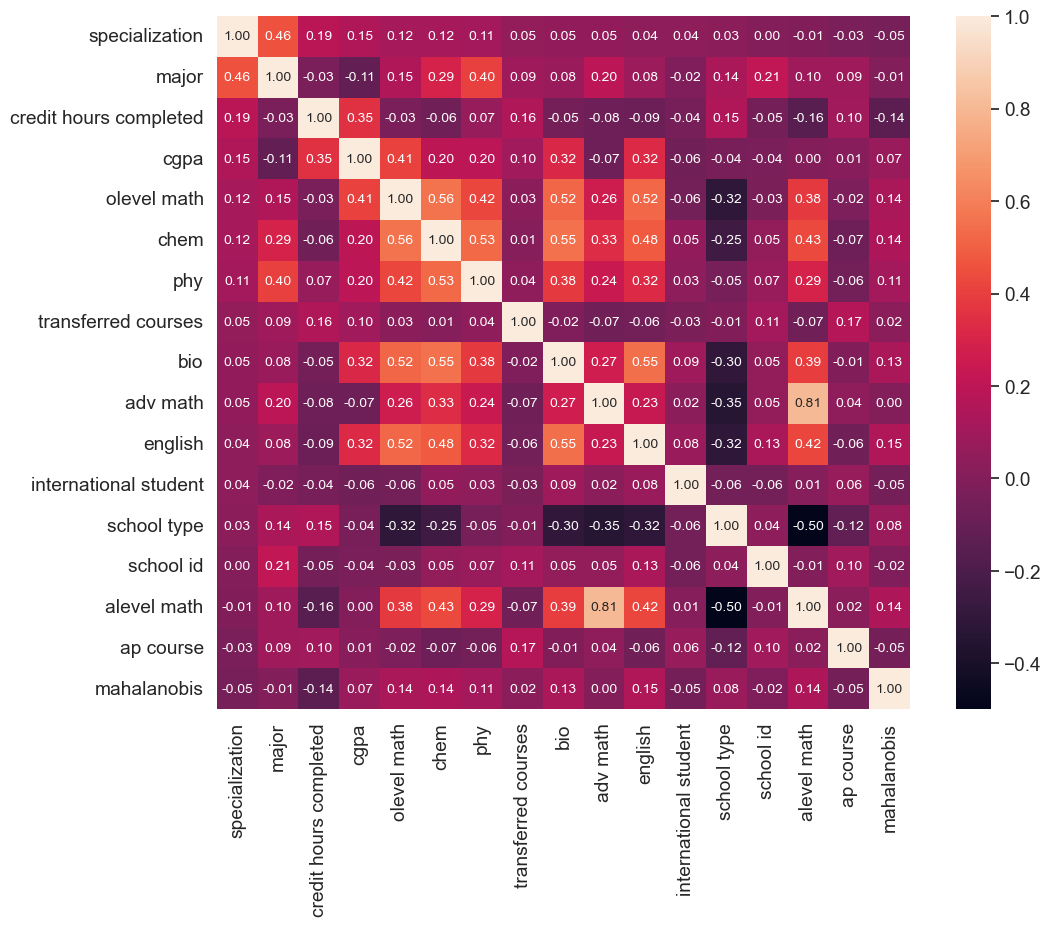

In [214]:
getZoomedCorrHeatMap(data, 17, 'specialization')

## Outlier Detection

Mahalanobis Distance - Multivariate Outlier Detection

In [227]:
df = data[['specialization','alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig', 'adv math', 
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'major', 'school type', 'school id']]

df['mahalanobis'] = mahalanobis(x=df, data=data[['specialization','alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig', 'adv math', 
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'major', 'school type', 'school id']])

C:\Users\Islam.Anwar\AppData\Local\Temp\ipykernel_25832\4252063784.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mahalanobis'] = mahalanobis(x=df, data=data[['specialization','alevel math', 'olevel math', 'chem', 'phy', 'bio',


In [228]:
df.head()

,specialization,alevel math,olevel math,chem,phy,bio,english,ap course,cs ig,adv math,international student,transferred courses,cgpa,credit hours completed,major,school type,school id,mahalanobis
0,1,0,9,2,1,1,7,0,0,0,0,0,19,21,0,5,40,5.304317
1,7,25,39,40,35,0,36,0,0,1,0,0,17,27,2,0,31,24.147727
2,1,2,15,9,17,1,7,0,0,1,0,0,50,40,0,5,35,14.246492
3,1,9,9,17,17,17,14,0,0,1,0,0,22,19,0,5,26,11.055102
4,1,18,27,0,36,0,28,0,0,1,0,0,36,18,0,0,16,21.603486


Chi Squared Test - Finding Outlier Rows

In [229]:
from scipy.stats import chi2
df['p'] = 1 - chi2.cdf(df['mahalanobis'], 16)

C:\Users\Islam.Anwar\AppData\Local\Temp\ipykernel_25832\2791323992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p'] = 1 - chi2.cdf(df['mahalanobis'], 16)


In [230]:
df

,specialization,alevel math,olevel math,chem,phy,bio,english,ap course,cs ig,adv math,international student,transferred courses,cgpa,credit hours completed,major,school type,school id,mahalanobis,p
0,1,0,9,2,1,1,7,0,0,0,0,0,19,21,0,5,40,5.304317,0.994021
1,7,25,39,40,35,0,36,0,0,1,0,0,17,27,2,0,31,24.147727,0.086327
2,1,2,15,9,17,1,7,0,0,1,0,0,50,40,0,5,35,14.246492,0.580356
3,1,9,9,17,17,17,14,0,0,1,0,0,22,19,0,5,26,11.055102,0.806071
4,1,18,27,0,36,0,28,0,0,1,0,0,36,18,0,0,16,21.603486,0.156462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,7,3,25,27,16,9,38,0,1,1,0,0,95,24,2,5,118,24.123761,0.086836
296,3,0,40,17,0,27,38,0,0,0,0,0,147,32,0,5,17,16.828738,0.396762
297,1,0,23,0,0,0,30,0,1,0,0,0,66,28,0,0,63,19.103567,0.263329
298,1,0,23,0,0,0,30,0,0,0,0,0,69,28,0,0,63,12.361136,0.718768


In [231]:
df.loc[df['p'] < 0.05].count()

specialization            33
alevel math               33
olevel math               33
chem                      33
phy                       33
bio                       33
english                   33
ap course                 33
cs ig                     33
adv math                  33
international student     33
transferred courses       33
cgpa                      33
credit hours completed    33
major                     33
school type               33
school id                 33
mahalanobis               33
p                         33
dtype: int64

In [250]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X = np.asarray(X)
y = np.asarray(y)


## Miscellaneous Preprocessing Steps

Splitting the data

In [254]:
# Stratified 10 Fold Cross Validation


Feature scaling

In [255]:
# Robust Scaler

# Feature Selection

# Model Selection

# Hyperparameter Optimization

# Local Model Interpretations